# ARIS-CH0 signal EDA

## Notebooks set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


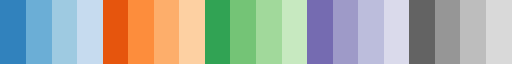

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Local imports
import configuration as config

# Create figures directory for saving plots
figures_dir = f'{config.FIGURES_DIRECTORY}/EDA'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Single planet

In [2]:
# Define path to example AIRS-CH0 signal file
airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/AIRS-CH0_signal_0.parquet'
print(f'Example AIRS-CH0 signal file path: {airs_file}')

Example AIRS-CH0 signal file path: ./data/raw/train/342072318/AIRS-CH0_signal_0.parquet


In [3]:
# Read the Parquet file and reshape into 3D array (frames, rows, cols)
signal = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356)
print(f'Raw signal shape: {signal.shape}')
print(f'Raw frame shape: {signal[0].shape}')

Raw signal shape: (11250, 32, 356)
Raw frame shape: (32, 356)


In [4]:
# Crop the frames - see here: https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data
# This removes unused columns to match wavelength indices
cut_inf, cut_sup = 39, 321
signal = signal[:, :, cut_inf:cut_sup]
print(f'Cropped signal shape: {signal.shape}')
print(f'Cropped frame shape: {signal[0].shape}')

Cropped signal shape: (11250, 32, 282)
Cropped frame shape: (32, 282)


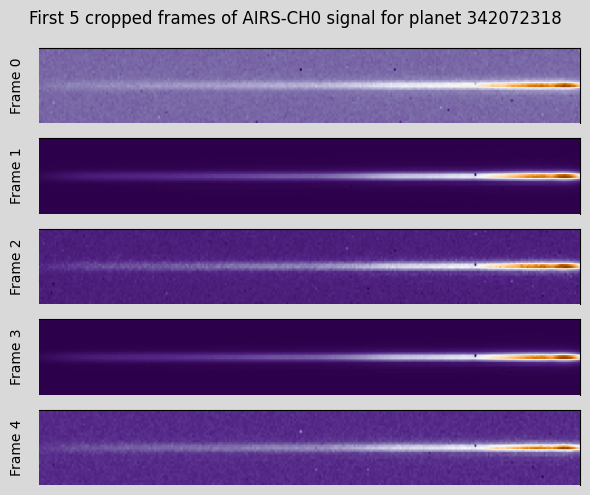

In [ ]:
# Plot the first few frames to visualize spectral data structure
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(config.STD_FIG_WIDTH, n_frames))
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)
axs = axs.flatten()

fig.suptitle(f'First {n_frames} cropped AIRS-CH0 frames for planet {config.SAMPLE_PLANET}')

for i in range(n_frames):

    frame = signal[i]

    # Normalize each frame by its mean for better visualization
    frame = frame.astype(float) / np.mean(frame.astype(float))

    axs[i].imshow(frame, aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
    axs[i].set_ylabel(f'Frame {i}')

    # Remove axis decorations for cleaner display
    axs[i].spines['left'].set_visible(False)    # Hide the left spine (axis line)
    axs[i].yaxis.set_ticks_position('none')     # Remove y-axis tick marks
    axs[i].set_yticklabels([])                  # Remove y-axis tick labels
    axs[i].spines['bottom'].set_visible(False)  # Hide the bottom spine (axis line)
    axs[i].xaxis.set_ticks_position('none')     # Remove x-axis tick marks
    axs[i].set_xticklabels([])                  # Remove x-axis tick labels

fig.tight_layout()

# Save the visualization
fig.savefig(
    f'{figures_dir}/01.3-AIRS_sample_frames.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

OK - I get it. Those smears are spectra - Ariel must put the signal through a grism or prism or something. Nice hint from the competition organizers about cropping the frames with `[:, :, 39:321]`, now we have a 1 to 1 correspondence between the pixels across the observed spectra and the wavelengths (though let's not assume no overlap...). One **more** hint they dropped in the [preprocessing notebook](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) they shared is: '*Data reduction is crucial in astronomical observations*'. We should be able to isolate the 'strip' that contains the actual data. I also now understand why they included the guidance camera frames - it will probably make it much easier to spot exoplanet transits than trying to use these IR spectra smears.

Still not sure how exactly to get the uncertainties - some kind of bootstrapping probably.

Here's the tentative plan:

1. Figure out how to efficiently spot transits in the FGS data.
2. Use transit info from FGS data to isolate transit spectral data from AIRS.
3. Use some kind of bootstrapping or ensemble method to learn the spectrum and get uncertainties.

Last, save some frames for testing.

In [6]:
# Save sample frames for unit testing
test_planet = f'{config.DATA_DIRECTORY}/raw/train/{config.SAMPLE_PLANET}'
Path(test_planet).mkdir(parents=True, exist_ok=True)

# Load original data and extract first N frames for testing
signal = pd.read_parquet(f'{test_planet}/AIRS-CH0_signal_0.parquet').to_numpy().reshape(11250, 32, 356)
test_frame = signal[:config.SAMPLE_FRAMES]
test_frame = test_frame.flatten()

# Create test data directory structure
test_planet = f'./tests/test_data/raw/train/{config.SAMPLE_PLANET}'
Path(test_planet).mkdir(parents=True, exist_ok=True)

# Save test frames as parquet file
with open(f'{test_planet}/AIRS-CH0_signal_0.parquet', 'wb') as f:
    pd.DataFrame(test_frame).to_parquet(f)